## The Data

### First overall glance

We first check the general look of the data. \
What is in front of us? \
How much data do we have? \
How is the data organized? \
What type of data is each part of?

So we read the data with one line in pandas and \
get some overview with simple print statements.

In [2]:
import pandas as pd

data = data_csv = pd.read_csv('.\pump_data\pump_sensor.csv') # read data from csv file
print(data.shape) # print the size of the data
# print(data.keys()) # print the column names
# print(data.head()) # print the first 5 rows of the data

(220320, 55)


### Output

From the print above we can derive that the CSV file \
contains 55 columns, with each over 200k entries.

The data is separated into *52 sensor columns*, one \
*machine status (target/results) column*, a *timestamp column*, \
and one *Unnamed column*, which is just the original index column.

From the timestamp we can see that the data is recorded \
in *1-minute steps*. The sensor data is in *float32* with \
varying aplitude and the timestamp is in the \
*yyyy-mm-dd hh:mm:ss format*.

## Target Data(y)

The second most important thing is to take a look at the \
*target data (y data / results)*. This will give some \
indication for the solution strategy.

After the first glimpse at the data, we have to check what \
*results (called target)* are provided which we can later use \
to identify/define our predictive maintenance goal/path.

### Some questions about extracting the target data are :
1. Do we have **target information**, or will it be an **unsupervised task**?
2. Are the target data **continuous data** or **booleans**?
3. What data type is the target in? **Values, text, …**
4. In what intervals are the targets recorded? \
   Does every sensor entry get a **single entry**, or are they **grouped**?
5. Does each sensor have its own target **(one machine — one sensor)** \
   or do we have one target for all sensors **(one machine — many sensors)**?
6. Is the target **descriptive**, or do we have to identify what \
   counts as **broken** and what as **normal**?
7. Is the target information complete and useful?

To get some answers, we will get the unique classes and see how many \
values we have for each class. Finding, that the labels are in char \
format (text), we know, that we will have to convert them at some \
point into integer values to be useable for our later Ml algorithms.

status options: 
['NORMAL' 'BROKEN' 'RECOVERING']

status count: 
NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64



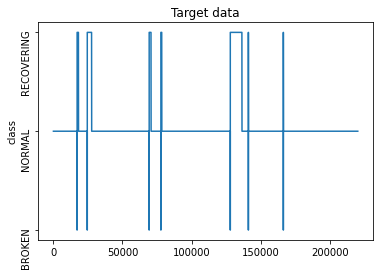

In [3]:
import sys
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt


'''
Get some info on the target-data
'''

data_status = data['machine_status'] # get the target data

# Get the unique values for the class
print('status options: ')
print(data_status.unique())
print()

# Count the number of each class
print('status count: ')
print(data_status.value_counts())
print()


'''
Convert the classes from string to values by using the scikit-learn mapper
'''

le = preprocessing.LabelEncoder() # get the label encoder
data = np.array(data_status) # get the target data
le.fit(data.flatten()) # fit the encoder to the data, flatten() is used to make the data 1D

# the following line assigns each entry of 'data' a number
# 0 for 'BROKEN', 1 for 'NORMAL' and 2 for 'RECOVERING'
encoded_y = pd.DataFrame(le.transform(data), columns=['target'])

# with open('long_output.txt', 'w') as f:
#     f.write(encoded_y.to_string())
#     f.close()
# sys.exit(0)

# Get the Label map
# To be able to later indentify what is what, create a label map
# Same as:
# le_name_mapping = {
#     'BROKEN': 0,
#     'NORMAL': 1,
#     'RECOVERING': 2
# }
# zip() creates a list of tuples, where each tuple is a pair of elements
# the elements are taken from the two lists given as arguments
# le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
# print(le_name_mapping)


'''
Plot the target data
'''

labels = data_status.unique().tolist() # get the class names
x = np.linspace(1, len(encoded_y), len(encoded_y)) # create x-axis (could also be timestamp column)
plt.plot(x, encoded_y)
plt.ylabel('class')
plt.title('Target data')
plt.yticks([1, 0, 2], labels, rotation='vertical') # Set the y-ticks to three to only show the classnames
plt.show()

### Output

We see that there are 3 classes in the dataset. \
As mentioned, they are in text form and give us already \
a good indication of what it is about. In other cases, \
you might just receive a status [A, B, C] or similar.

After counting the values in each class, we see that we have \
the majority class *Normal*, which is to be expected, as the \
machine should run normally the majority of the time. The \
classes *Recovering* and *Broken* are the minority classes. \
We see directly, that we most likely cannot work with the \
*Broken* class, as **seven** values are not enough to learn any pattern.

We also see that by counting the values together, we receive \
the same amount as existing rows. This means there are no \
missing values (NaN) in the target data (of course that could \
also be checked with an isna() function).

The plot of the target shows us that the faulty sections \
are not grouped up at e.g., the end, but are rather dispersed \
over the entire data length. This is interesting for a later \
segmentation into train and test sets. We also see, that the \
*Recovering* class always follows the *Broken* class. This means \
that it is not a problem to have only *7* entries for the *Broken* \
class, as we just have to predict the recovering phase to also \
get the *Broken* class.


### Results :

We have good and complete target data. \
We have one entry for each row, resulting \
    in a *one-machine:many-sensors supervised* \
    learning task.